# MNIST classification

Timings here are for a machine with a K80 GPU (an Azure NC6 instance). Running with a CPU only machine is going to quite a bit slower. 

**This requires tensorflow 1.0. For some reason things are breaking on tensorflow 1.1 (https://github.com/GPflow/GPflow/issues/415)**

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.append('../src')

import numpy as np
import tensorflow as tf

from gpflow.likelihoods import MultiClass
from gpflow.kernels import RBF, White, Linear, Matern32, Matern52
from gpflow.svgp import SVGP
from gpflow.gpr import GPR

from gpflow.param import AutoFlow

from scipy.stats import mode
from scipy.cluster.vq import kmeans2

from get_data import get_mnist_data
from dgp import DGP

import time

X, Y, Xs, Ys = get_mnist_data()

Extracting ../data/MNIST_data/train-images-idx3-ubyte.gz
Extracting ../data/MNIST_data/train-labels-idx1-ubyte.gz
Extracting ../data/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ../data/MNIST_data/t10k-labels-idx1-ubyte.gz


We'll use 100 inducing points 

In [2]:
M = 100
Z = kmeans2(X, M, minit='points')[0]

Slightly annoyingly,  `AutoFlow` takes `Ynew` as a `float_type` in `predict_density`, but for the mutliclass likelihood the input is `tf.int32` (also the number of dimensions are different). We defined both versions in our `DGP` class, but as a workaround for `SVGP` we just override the behaviour:


In [3]:
class MultiClassSVPG(SVGP):
    @AutoFlow((tf.float64, [None, None]), (tf.int32, [None,]))
    def predict_density(self, Xnew, Ynew):
        pred_f_mean, pred_f_var = self.build_predict(Xnew)
        return self.likelihood.predict_density(pred_f_mean, pred_f_var, Ynew)

We'll compare three models: an ordinary sparse GP and DGPs with 2 and 3 layers. 

We'll use a batch size of 10000 for all models 

In [4]:
m_sgp = MultiClassSVPG(X, Y, RBF(784, lengthscales=2, variance=2), 
             MultiClass(10), Z, 
             num_latent=10, minibatch_size=10000, whiten=True)

def make_dgp(L):
    kernels = [RBF(784, lengthscales=2., variance=2.)]
    for l in range(L-1):
        kernels.append(RBF(30, lengthscales=2., variance=2.))
    model = DGP(X, Y, Z, kernels, MultiClass(10), 
                num_samples=1,
                minibatch_size=10000,
                num_latent_Y=10)

    for layer in model.layers[:-1]:
        layer.q_sqrt = layer.q_sqrt.value * 1e-5 
    
    return model

m_dgp2 = make_dgp(2)
m_dgp3 = make_dgp(3)

For the SGP model we'll calcuate accuracy by simply taking the max mean prediction:

In [5]:
def assess_model_sgp(model, X_batch, Y_batch):
    m, v = model.predict_y(X_batch)
    l = model.predict_density(X_batch, Y_batch)
    a = (np.argmax(m, 1)==Y_batch)
    return l, a

For the DGP models we have stochastic predictions. We need a single prediction for each datum, so to do this we take $S$ samples for the one-hot predictions ($(S, N, 10)$ matrices for mean and var), then we take the max over the class means (to give a $(S, N)$ matrix), and finally we take the modal class over the samples (to give a vector of length $N$):

We'll use 100 samples

In [6]:
S = 100
def assess_model_dgp(model, X_batch, Y_batch):
    m, v = model.predict_y(X_batch, S)
    l = model.predict_density_multiclass(X_batch, Y_batch, S)
    a = (mode(np.argmax(m, 2), 0)[0].flatten()==Y_batch)
    return l, a

We need batch predictions (we might run out of memory otherwise)

In [7]:
def batch_assess(model, assess_model, X, Y):
    n_batches = int(len(X)/1000)
    lik, acc = [], []
    for X_batch, Y_batch in zip(np.split(X, n_batches), np.split(Y, n_batches)):
        l, a = assess_model(model, X_batch, Y_batch)
        lik.append(l)
        acc.append(a)
    lik = np.concatenate(lik, 0)
    acc = np.array(np.concatenate(acc, 0), dtype=float)
    return np.average(lik), np.average(acc)

Finally, we'll use the following callback to log what's going on. We'll train for 10000 iterations, printing every 1000 to see how convergence is doing. We'll predict also at the training data to see what's going (we don't use a validation set). 

In [8]:
class CB(object):
    def __init__(self, model, assess_model):
        self.model = model
        self.assess_model = assess_model
        self.i = 0
        self.t = time.time()
        self.train_time = 0
        self.ob = []
        self.train_lik = []
        self.train_acc = []
    def cb(self, x):
        self.i += 1
        if self.i % 1000 == 0:
            # time how long we've be training 
            self.train_time += time.time() - self.t
            self.t = time.time()
            
            # assess the model on the training data
            self.model.set_state(x)
            lik, acc = batch_assess(self.model, self.assess_model, X, Y)
            self.train_lik.append(lik)
            self.train_acc.append(acc)
            
            # calculate the objective, averaged over S samples 
            ob = 0
            for _ in range(1):
                ob += self.model.compute_log_likelihood()/float(1)
            self.ob.append(ob)
            
            st = 'it: {}, ob: {:.1f}, train lik: {:.4f}, train acc {:.4f}'
            print st.format(self.i, ob, lik, acc)

Now we're ready to go

The sparse GP:

In [9]:
cb_sgp = CB(m_sgp, assess_model_sgp)
m_sgp.optimize(tf.train.AdamOptimizer(0.01), maxiter=10000, callback=cb_sgp.cb)
print 'sgp total train time {:.4f}'.format(cb_sgp.train_time)
l, a = batch_assess(m_sgp, assess_model_sgp, Xs, Ys)
print 'spg test lik: {:.4f}, test acc {:.4f}'.format(l, a)

it: 1000, ob: -33154.9, train lik: -0.1107, train acc 0.9728
it: 2000, ob: -28451.0, train lik: -0.0937, train acc 0.9788
it: 3000, ob: -28337.6, train lik: -0.0895, train acc 0.9802
it: 4000, ob: -27294.9, train lik: -0.0863, train acc 0.9806
it: 5000, ob: -27199.4, train lik: -0.0865, train acc 0.9812
it: 6000, ob: -27522.2, train lik: -0.0854, train acc 0.9817
it: 7000, ob: -26544.2, train lik: -0.0831, train acc 0.9821
it: 8000, ob: -27154.6, train lik: -0.0833, train acc 0.9817
it: 9000, ob: -27591.8, train lik: -0.0834, train acc 0.9816
it: 10000, ob: -27926.8, train lik: -0.0829, train acc 0.9820
sgp total train time 1429.0665
spg test lik: -0.0973, test acc 0.9728


Using more inducing points improves things, but at the expense of very slow computation (500 inducing points takes about a day)

The two layer DGP:

In [10]:
cb_dgp2 = CB(m_dgp2, assess_model_dgp)
m_dgp2.optimize(tf.train.AdamOptimizer(0.01), maxiter=10000, callback=cb_dgp2.cb)
print 'dgp2 total train time {:.4f}'.format(cb_dgp2.train_time)
l, a = batch_assess(m_dgp2, assess_model_dgp, Xs, Ys)
print 'dgp2 test lik: {:.4f}, test acc {:.4f}'.format(l, a)

it: 1000, ob: -31624.0, train lik: -0.0790, train acc 0.9809
it: 2000, ob: -25995.5, train lik: -0.0642, train acc 0.9857
it: 3000, ob: -23320.1, train lik: -0.0589, train acc 0.9877
it: 4000, ob: -21757.0, train lik: -0.0576, train acc 0.9880
it: 5000, ob: -19803.2, train lik: -0.0555, train acc 0.9888
it: 6000, ob: -19860.2, train lik: -0.0548, train acc 0.9888
it: 7000, ob: -19172.3, train lik: -0.0540, train acc 0.9893
it: 8000, ob: -19212.3, train lik: -0.0545, train acc 0.9891
it: 9000, ob: -19373.0, train lik: -0.0546, train acc 0.9893
it: 10000, ob: -19533.8, train lik: -0.0532, train acc 0.9895
dgp2 total train time 3543.4270
dgp2 test lik: -0.0703, test acc 0.9804


And the three layer:

In [12]:
cb_dgp3 = CB(m_dgp3, assess_model_dgp)
m_dgp3.optimize(tf.train.AdamOptimizer(0.01), maxiter=10000, callback=cb_dgp3.cb)
print 'dgp3 total train time {:.4f}'.format(cb_dgp3.train_time)
l, a = batch_assess(m_dgp3, assess_model_dgp, Xs, Ys)
print 'dgp3 test lik: {:.4f}, test acc {:.4f}'.format(l, a)

it: 1000, ob: -35776.0, train lik: -0.0726, train acc 0.9824
it: 2000, ob: -29525.7, train lik: -0.0624, train acc 0.9866
it: 3000, ob: -26970.0, train lik: -0.0578, train acc 0.9875
it: 4000, ob: -24884.1, train lik: -0.0551, train acc 0.9887
it: 5000, ob: -22423.2, train lik: -0.0544, train acc 0.9891
it: 6000, ob: -21019.2, train lik: -0.0537, train acc 0.9891
it: 7000, ob: -20946.4, train lik: -0.0530, train acc 0.9891
it: 8000, ob: -20679.7, train lik: -0.0528, train acc 0.9892
it: 9000, ob: -20330.9, train lik: -0.0521, train acc 0.9896
it: 10000, ob: -21785.5, train lik: -0.0521, train acc 0.9894
dgp3 total train time 5486.0293
dgp3 test lik: -0.0681, test acc 0.9811


The 3 layer DGP is best on both accuracy and likelihood, though the improvement over the 2 layer is slight. 

We can see how they've done over the training

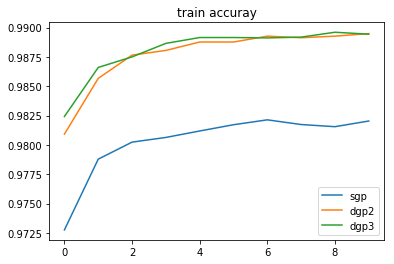

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(cb_sgp.train_acc, label='sgp')
plt.plot(cb_dgp2.train_acc, label='dgp2')
plt.plot(cb_dgp3.train_acc, label='dgp3')
plt.title('train accuray')
plt.legend()
plt.show()

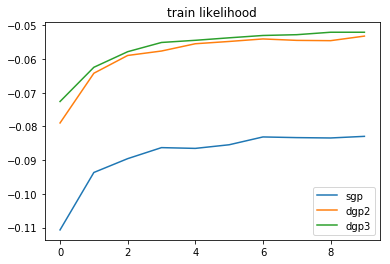

In [16]:
plt.plot(cb_sgp.train_lik, label='sgp')
plt.plot(cb_dgp2.train_lik, label='dgp2')
plt.plot(cb_dgp3.train_lik, label='dgp3')
plt.title('train likelihood')
plt.legend()
plt.show()